<img src="Figs/Banner.png" width="100%" />
<font face="Calibri">
<br>
<font size="7"> <b> GEOS 657 Microwave Remote Sensing <b> </font>

<font size="5"> <b> Lab 9: InSAR Time Series Analysis using MintPy and ARIA products</b> </font>
<br> <img src="Figs/NASALogo.png" width="250" align="right" /> <br> 
<font size="4"> <b> Eric Fielding, David Bekaert, Heresh Fattahi and Zhang Yunjun with modifications by Franz J Meyer</b> 
<font size="3">  <br>
<font> <b>Date: </b> April 19, 2023 </font>
</font>

<font face="Calibri" size="3">This notebook is a second modification by Eric Fielding from an earlier version of the notebook (https://nbviewer.jupyter.org/github/aria-tools/ARIA-tools-docs/blob/master/JupyterDocs/NISAR/L2_interseismic/mintpySF/smallbaselineApp_aria.ipynb) by David Bekaert, Heresh Fattahi and Zhang Yunjun that was originally focused on San Francisco. 

 This notebook is a modification from the [original](https://nbviewer.jupyter.org/github/insarlab/MintPy-tutorial/blob/main/smallbaselineApp_aria.ipynb) by Heresh Fattahi and Zhang Yunjun. 


**Mapping landslide motion with InSAR time series**

The Caltech-JPL ARIA project in partnership with NASA Getting Ready for NISAR (GRFN) project has been generated surface displacement products (interferograms) mimicking the NISAR L2 GUNW (Geocoded Unwrapped phase interferograms) product formatting. The interferograms are stored at the NASA ASF DAAC, and are accessible with an Open Source set of tools called ARIA-tools. The Miami Insar Timeseries software in PYthon (MintPy), an open-source package for InSAR time-series analysis, is compatible with the outputs from the ARIA-tools package, and in combination with the ARIA-tools pre-processor can be used to estimate ground displacement time-series. 

The Jupyter notebook presented here is meant as an practical example on the use of Jupyter for exploring landslide displacements. In the example below, we will demonstrate a time-series derived from ARIA standard InSAR products over the Los Angeles, California area revealing landslide motion on the Palos Verdes peninsula. 

See the other tutorials on ARIA-tools to learn more about how to use that package.
</font>

<font face="Calibri" size="3">
<div class="alert alert-warning">
<b>To save time, we have pre-ran the ARIA-tools package and data loading into MintPy</b> 

```!ariaDownload.py -b '33.5 34.5 -119.0 -117.9' --track 71```
    
```!ariaTSsetup.py -f 'products/*.nc' -b '33.65 33.9 -118.45 -118.15' --mask Download```
    
```!smallbaselineApp.py -t LASenDT71.txt --dostep load_data```
    

</div>
</font>

<font face="Calibri" size="3">
<div class="alert alert-warning">
 
<b>The staged data was uploaded to an S3 data bucket in AWS so that they can be easily downloaded into the OpenSARLab:</b>
    
```!aws --region=us-west-2 --no-sign-request s3 cp s3://asf-jupyter-data-west/Fielding/Stack.zip Stack.zip```

When users are not leveraging openSARlabs, they should start from ARIA-tools as download from S3 will not work.
</div>
</font>

<div class="alert alert-danger">
<font face="Calibri" size="4"> <font color='rgba(200,0,0,0.2)'> <b>THIS NOTEBOOK IS FOR ILLUSTRATIVE PURPOSES ONLY AND DOES NOT INCLUDE A HOMEWORK ASSIGNMENT!</b></font> 
</font>
</div>

In [1]:
import url_widget as url_w
notebookUrl = url_w.URLWidget()
display(notebookUrl)

URLWidget()

In [2]:
from IPython.display import Markdown
from IPython.display import display

notebookUrl = notebookUrl.value
user = !echo $JUPYTERHUB_USER
env = !echo $CONDA_PREFIX
if env[0] == '':
    env[0] = 'Python 3 (base)'
if env[0] != '/home/jovyan/.local/envs/insar_analysis':
    display(Markdown(f'<text style=color:red><strong>WARNING:</strong></text>'))
    display(Markdown(f'<text style=color:red>This notebook should be run using the "insar_analysis" conda environment.</text>'))
    display(Markdown(f'<text style=color:red>It is currently using the "{env[0].split("/")[-1]}" environment.</text>'))
    display(Markdown(f'<text style=color:red>Select "insar_analysis" from the "Change Kernel" submenu of the "Kernel" menu.</text>'))
    display(Markdown(f'<text style=color:red>If the "insar_analysis" environment is not present, use <a href="{notebookUrl.split("/user")[0]}/user/{user[0]}/notebooks/conda_environments/Create_OSL_Conda_Environments.ipynb"> Create_OSL_Conda_Environments.ipynb </a> to create it.</text>'))
    display(Markdown(f'<text style=color:red>Note that you must restart your server after creating a new environment before it is usable by notebooks.</text>'))

# 0. Notebook setup

The two cells below must be run each time the notebook is started to ensure correct set-up of the notebook.

In [53]:
import os
import zipfile
import numpy as np

# verify mintpy install is complete:
try:
    # for MintPy v1.4.1+
    from mintpy.cli import view, tsview, plot_network, plot_transection, plot_coherence_matrix
    
    ## for MintPy v1.4 and below. Uncomment this if you have an older version of MintPy.
    # from mintpy import view, tsview, plot_network, plot_transection, plot_coherence_matrix
except ImportError:
    raise ImportError("Looks like mintPy is not fully installed")

import opensarlab_lib as asfn
from osgeo import gdal
import contextlib
import csv
from datetime import datetime
import h5py
import os
from pathlib import Path
import re
import urllib
import zipfile
import mintpy.objects.insar_vs_gps
import mintpy.utils

In [4]:
# define the work directory
work_dir = f"{os.path.abspath(os.getcwd())}/data_LA"
print("Work directory: ", work_dir)
if not os.path.isdir(work_dir):
    os.makedirs(work_dir)
    print(f'Create directory: {work_dir}')
print(f'Go to work directory: {work_dir}')
os.chdir(work_dir)  
    
if not os.path.isfile('Stack.zip'):
    !aws --region=us-west-2 --no-sign-request s3 cp s3://asf-jupyter-data-west/Fielding/Stack.zip Stack.zip 
      
# verify if download was succesfull
if os.path.isfile('Stack.zip'):
    with zipfile.ZipFile('Stack.zip', 'r') as zip_ref:
        zip_ref.extractall(os.getcwd())
    print('S3 pre-staged data retrieval was successfull')
else:
    print("Download outside openSarLabs is not supported.\nAs alternative please start from ARIA-tools with the commandline calls provided at the top of this notebook")          


Work directory:  /home/jovyan/GEOS657_MRS/2023/data_LA
Create directory: /home/jovyan/GEOS657_MRS/2023/data_LA
Go to work directory: /home/jovyan/GEOS657_MRS/2023/data_LA
download: s3://asf-jupyter-data-west/Fielding/Stack.zip to ./Stack.zip
S3 pre-staged data retrieval was successfull


<font face="Calibri" size="3">The following command will download all the ARIA standard products over the LA area, which is 575 products at the time of this writing. This will take more than two hours to complete if the data is not already downloaded.</font>

In [5]:
# download data for descending track 71 over Los Angeles area
#!ariaDownload.py -b '33.5 34.5 -119.0 -117.9' --track 71

<font face="Calibri" size="3">This ARIA time-series setup would cover the whole Los Angeles area and would take a while to process, so we are skipping this setup.</font>

In [6]:
#!ariaTSsetup.py -f 'products/*.nc' -b '33.5 34.5 -119.0 -117.9' --mask Download

<font face="Calibri" size="3">The following ARIA time-series setup `ariaTSsetup.py` extracts the data that covers only a small area around the Palos Verdes peninsula southwest of Los Angeles to speed the time-series processing, which we specify with the bounding box. We also download the water mask to avoid using data over the ocean.</font>

In [7]:
#!ariaTSsetup.py -f 'products/*.nc' -b '33.65 33.9 -118.45 -118.15' --mask Download

# 1. smallbaselineApp.py overview

<font face="Calibri" size="3">This application provides a workflow which includes several steps to invert a stack of unwrapped interferograms and apply different corrections to obtain ground displacement timeseries.  
The workflow consists of two main blocks:

* correcting unwrapping errors and inverting for the raw phase time-series (blue ovals),
* correcting for noise from different sources to obtain the displacement time-series (green ovals).

Some steps are optional, which are switched off by default (marked by dashed boundaries). Configuration parameters for each step are initiated with default values in a customizable text file: [smallbaselineApp.cfg](https://github.com/insarlab/MintPy/blob/master/mintpy/defaults/smallbaselineApp.cfg). In this notebook, we will walk through some of these steps, for a complete example see the [MintPy repository](https://github.com/insarlab/MintPy).

<p align="left">
  <img width="600" src="NotebookAddons/MintPyWorkflow.jpg">
</p>     
<p style="text-align: center;">
    (Figure from Yunjun et al., 2019)
</p>
</font>

## 1.1 Processing Steps of smallbaselineApp.py

<font face="Calibri" size="3">The MintPy **smallbaselineApp.py** application provides a workflow to invert a stack of unwrapped interferograms and apply different (often optional) corrections to obtain ground displacement timeseries. A detailed overview of the options can be retrieved by involking the help option:</font>

In [8]:
!smallbaselineApp.py --help

usage: smallbaselineApp.py [-h] [--dir WORKDIR] [-g] [-H] [-v] [--plot]
                           [--start STEP] [--end STEP] [--dostep STEP]
                           [customTemplateFile]

Routine Time Series Analysis for Small Baseline InSAR Stack

positional arguments:
  customTemplateFile    custom template with option settings.
                        ignored if the default smallbaselineApp.cfg is input.

optional arguments:
  -h, --help            show this help message and exit
  --dir WORKDIR, --work-dir WORKDIR
                        work directory, (default: ./).
  -g                    generate default template (if it does not exist) and exit.
  -H                    print the default template file and exit.
  -v, --version         print software version and exit
  --plot                plot results [only] without running smallbaselineApp.

steps processing (start/end/dostep):
  Command line options for steps processing with names are chosen from the following list:
  
  

## 1.2 Configuring Processing Parameters

<font face="Calibri" size="3">The processing parameters for the **smallbaselineApp.py** are controlled through a configuration file. If no file is provided the default [smallbaselineApp.cfg](https://github.com/insarlab/MintPy/blob/master/mintpy/defaults/smallbaselineApp.cfg) configuration is used. Here we use `LASenDT71.txt`, which already constains selected, manually modified configuration parameters for this time-series analysis.</font>

<hr>

# 2. Small Baseline Time Series Analysis

## 2.1. Loading ARIA data into MintPy

<font face="Calibri" size="3">The [ARIA-tools package](https://github.com/aria-tools/ARIA-tools) is used as a pre-processor for MintPY. It has a download tool that wraps around the ASF DAAC API, and includes tools for stitching/cropping and time-series preparation. The output of the time-series preparation is compatible with the [data directory](https://mintpy.readthedocs.io/en/latest/dir_structure/) structure from MintPy. To save time, we have already pre-ran these steps. The commands used were:

```!ariaDownload.py -b '33.5 34.5 -119.0 -117.9' --track 71```

```!ariaTSsetup.py -f 'products/*.nc' -b '33.65 33.9 -118.45 -118.15' --mask Download```
</font>

<font face="Calibri" size="3">The `ariaTSsetup.py` step above (or the pre-processed Stack.zip) extracted the data for the subset we specified and found a total of 439 products that cover our study area. Now we load the data for the subset area into MintPy.</font>

In [9]:
# define the MintPy time-series directory
mint_dir = work_dir+'/MintPy'
print("MintPy directory: ", mint_dir)
if not os.path.isdir(mint_dir):
    os.makedirs(mint_dir)
    print('Create directory: {}'.format(mint_dir))

# copy the configuration file
os.chdir(work_dir)  
!cp LASenDT71.txt MintPy

print('Go to work directory: {}'.format(mint_dir))
os.chdir(mint_dir)  

!smallbaselineApp.py LASenDT71.txt --dostep load_data

MintPy directory:  /home/jovyan/GEOS657_MRS/2023/data_LA/MintPy
Create directory: /home/jovyan/GEOS657_MRS/2023/data_LA/MintPy
Go to work directory: /home/jovyan/GEOS657_MRS/2023/data_LA/MintPy
MintPy version 1.5.0, date 2022-11-18
--RUN-at-2023-04-20 04:08:58.952614--
Current directory: /home/jovyan/GEOS657_MRS/2023/data_LA/MintPy
Run routine processing with smallbaselineApp.py on steps: ['load_data']
Remaining steps: ['modify_network', 'reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: LASenDT71
Go to work directory: /home/jovyan/GEOS657_MRS/2023/data_LA/MintPy
copy default template file /home/jovyan/.local/envs/insar_analysis/lib/python3.8/site-packages/mintpy/defaults/smallbaselineApp.cfg to work directory
read custom templa

<font face="Calibri" size="3">The output of the loading step is an "inputs" directory containing two HDF5 files:
- ifgramStack.h5: This file contains 6 dataset cubes (e.g. unwrapped phase, coherence, connected components etc.) and multiple metadata.  
- geometryGeo.h5: This file contains geometrical datasets (e.g., incidence/azimuth angle, masks, etc.). 
</font>

In [10]:
!ls inputs

geometryGeo.h5	ifgramStack.h5	LASenDT71.txt  smallbaselineApp.cfg


<font face="Calibri" size="3">
<div class="alert alert-info">
<b>info.py :</b> 
To get general infomation about a MintPy product, run info.py on the file.   
</div>
</font>

In [11]:
!info.py inputs/ifgramStack.h5

******************** Basic File Info ************************
file name: /home/jovyan/GEOS657_MRS/2023/data_LA/MintPy/inputs/ifgramStack.h5
file type: ifgramStack
coordinates : GEO

******************** HDF5 File Structure ********************
Attributes in / level:
  ALOOKS                                          7
  ANTENNA_SIDE                                    -1
  CENTER_LINE_UTC                                 49952.0
  EARTH_RADIUS                                    6337286.638938101
  FILE_LENGTH                                     301
  FILE_TYPE                                       ifgramStack
  HEADING                                         -168
  HEIGHT                                          693000.0
  LAT_REF1                                        33.900416666666665
  LAT_REF2                                        33.900416666666665
  LAT_REF3                                        33.64958333333337
  LAT_REF4                                        33.6495833333333

In [12]:
!info.py inputs/geometryGeo.h5

******************** Basic File Info ************************
file name: /home/jovyan/GEOS657_MRS/2023/data_LA/MintPy/inputs/geometryGeo.h5
file type: geometry
coordinates : GEO

******************** HDF5 File Structure ********************
Attributes in / level:
  ALOOKS                                          7
  ANTENNA_SIDE                                    -1
  CENTER_LINE_UTC                                 49952.0
  EARTH_RADIUS                                    6337286.638938101
  FILE_LENGTH                                     301
  FILE_TYPE                                       geometry
  HEADING                                         -168
  HEIGHT                                          693000.0
  LAT_REF1                                        33.900416666666665
  LAT_REF2                                        33.900416666666665
  LAT_REF3                                        33.64958333333337
  LAT_REF4                                        33.64958333333337
  LE

## 2.2. Plotting the Interferogram Network

<font face="Calibri" size="3">Running **plot_network.py** gives an overview of the network and the average coherence of the stack. The program creates multiple files as follows:
- ifgramStack_coherence_spatialAvg.txt: Contains interferogram dates, average coherence temporal and spatial baseline separation.
- Network.pdf: Displays the network of interferograms on time-baseline coordinates, colorcoded by average coherence of the interferograms. 
- CoherenceMatrix.pdf shows the average coherence pairs between all available pairs in the stack.
</font>

MintPy version 1.5.0, date 2022-11-18
--RUN-at-2023-04-20 04:10:29.970171--
Current directory: /home/jovyan/GEOS657_MRS/2023/data_LA/MintPy
Run routine processing with smallbaselineApp.py on steps: ['modify_network']
Remaining steps: ['reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: LASenDT71
Go to work directory: /home/jovyan/GEOS657_MRS/2023/data_LA/MintPy
read custom template file: /home/jovyan/GEOS657_MRS/2023/data_LA/MintPy/LASenDT71.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/GEOS657_MRS/2023/data_LA/MintPy/smallbaselineApp.cfg
read default template file: /home/jovyan/GEOS657_MRS/2023/data_LA/MintPy/smallbaselineApp.cfg


******************** step - mod

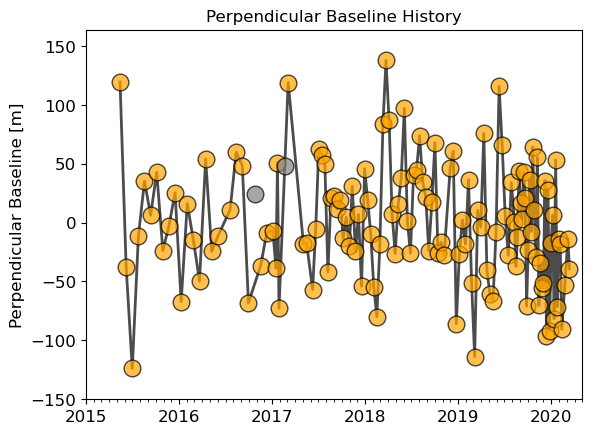

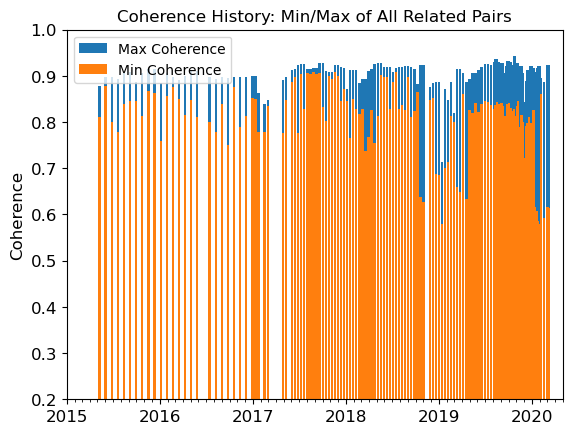

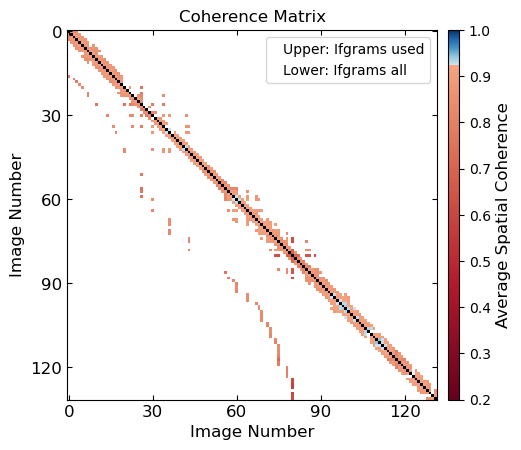

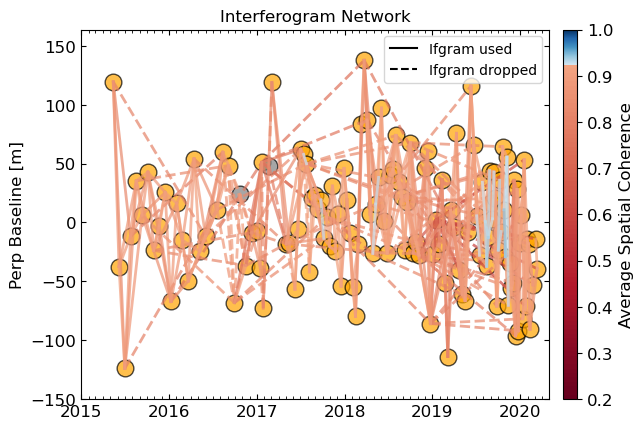

In [13]:
!smallbaselineApp.py LASenDT71.txt  --dostep modify_network
plot_network.main(['inputs/ifgramStack.h5'])

## 2.3.  Mask Generation

<font face="Calibri" size="3">Mask files can be can be used to mask pixels in the time-series processing. Below we generate a mask file based on the connected components, which is a metric for unwrapping quality.</font>

input ifgramStack file: inputs/ifgramStack.h5
--------------------------------------------------
update mode: ON
1) output file maskConnComp.h5 NOT exist.
run or skip: run.
calculate the common mask of pixels with non-zero connectComponent value
[==================================================] 341/341    3s /     0s
create HDF5 file: maskConnComp.h5 with w mode
create dataset /mask of bool       in size of (301, 361)           with compression=None
finished writing to maskConnComp.h5
time used: 00 mins 3.3 secs.
run view.py in MintPy version 1.5.0, date 2022-11-18
input file is mask file: /home/jovyan/GEOS657_MRS/2023/data_LA/MintPy/maskConnComp.h5 in bool format
file size in y/x: (301, 361)
num of datasets in file maskConnComp.h5: 1
datasets to exclude (0):
[]
datasets to display (1):
['mask']
data   coverage in y/x: (0, 0, 361, 301)
subset coverage in y/x: (0, 0, 361, 301)
data   coverage in lat/lon: (-118.450416667, 33.900416667, -118.149583454, 33.649583434)
subset coverage in 

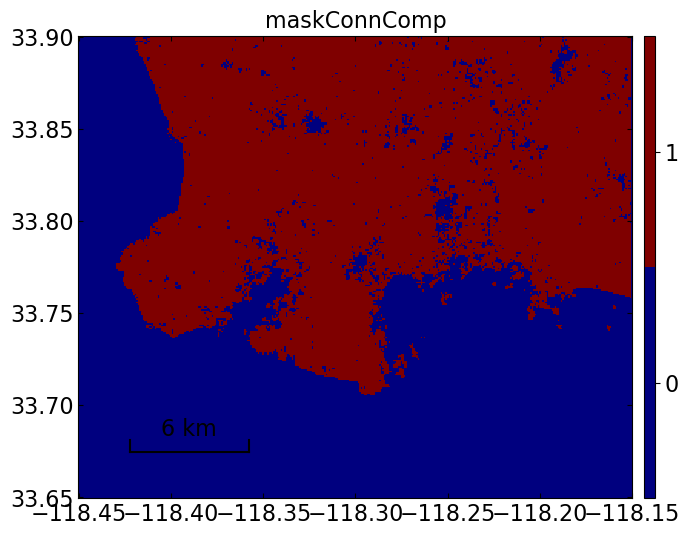

In [14]:
!generate_mask.py  inputs/ifgramStack.h5  --nonzero  -o maskConnComp.h5  --update
view.main(['maskConnComp.h5'])

In [15]:
#!view.py 

## 2.4 Reference Point Selection


<font face="Calibri" size="3">The interferometric phase is a relative observation by nature. The phases of each unwrapped interferogram are relative with respect to an arbitrary pixel. Therfore we need to reference all interferograms to a common reference pixel.
The step "reference_point" selects a common reference pixel for the stack of interferograms. The default approach of mintpy is to choose a pixel with highest spatial coherence in the stack. Other options include specifying the longitude and latitude of the desired reference pixel or the line and column number of the refence pixel.</font>

In [16]:
!smallbaselineApp.py LASenDT71.txt --dostep reference_point

MintPy version 1.5.0, date 2022-11-18
--RUN-at-2023-04-20 04:11:15.027013--
Current directory: /home/jovyan/GEOS657_MRS/2023/data_LA/MintPy
Run routine processing with smallbaselineApp.py on steps: ['reference_point']
Remaining steps: ['quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: LASenDT71
Go to work directory: /home/jovyan/GEOS657_MRS/2023/data_LA/MintPy
read custom template file: /home/jovyan/GEOS657_MRS/2023/data_LA/MintPy/LASenDT71.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/GEOS657_MRS/2023/data_LA/MintPy/smallbaselineApp.cfg
read default template file: /home/jovyan/GEOS657_MRS/2023/data_LA/MintPy/smallbaselineApp.cfg


******************** step - reference_point *****

<font face="Calibri" size="3">Running the "reference_step" adds additional attributes "REF_X, REF_Y" and "REF_LON, REF_LAT" to the ifgramStack.h5 file. To see the attributes of the file run info.py:</font>

In [17]:
!info.py inputs/ifgramStack.h5 | egrep 'REF_'

  REF_LAT                                         33.760000056500004
  REF_LON                                         -118.3616667025
  REF_X                                           106
  REF_Y                                           168


<font face="Calibri" size="3">In this case, I set the reference point latitude and longitude to be in a location close to the Portuguese Bend Landslide, and MintPy calculated the X and Y locations.</font>

## 2.5 Inverting the Small Baseline Network

<font face="Calibri" size="3">In the next step we invert the network of differential unwrapped interferograms to estimate the time-series of unwrapped phase with respect to a reference acquisition date. By default mintpy selects the first acquisition. The estimated time-series is converted to distance change from radar to target and is provided in meters. </font>

In [18]:
!smallbaselineApp.py LASenDT71.txt --dostep invert_network

MintPy version 1.5.0, date 2022-11-18
--RUN-at-2023-04-20 04:11:18.191625--
Current directory: /home/jovyan/GEOS657_MRS/2023/data_LA/MintPy
Run routine processing with smallbaselineApp.py on steps: ['invert_network']
Remaining steps: ['correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: LASenDT71
Go to work directory: /home/jovyan/GEOS657_MRS/2023/data_LA/MintPy
read custom template file: /home/jovyan/GEOS657_MRS/2023/data_LA/MintPy/LASenDT71.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/GEOS657_MRS/2023/data_LA/MintPy/smallbaselineApp.cfg
read default template file: /home/jovyan/GEOS657_MRS/2023/data_LA/MintPy/smallbaselineApp.cfg


******************** step - invert_network ********************
Input data seems to be geocoded. Lookup file n

<font face="Calibri" size="3">The timeseries file contains three datasets:
- the "time-series" which is the interferometric range change for each acquisition relative to the reference acquisition,
- the "date" dataset which contains the acquisition date for each acquisition,
- the "bperp" dataset which contains the timeseries of the perpendicular baseline.  
</font>

## 2.6 Plot the corrected, inverted time series steps

run view.py in MintPy version 1.5.0, date 2022-11-18
input file is timeseries file: /home/jovyan/GEOS657_MRS/2023/data_LA/MintPy/timeseries.h5 in float32 format
file size in y/x: (301, 361)
num of datasets in file timeseries.h5: 130
datasets to exclude (0):
[]
datasets to display (130):
['timeseries-20150514', 'timeseries-20150607', 'timeseries-20150701', 'timeseries-20150725', 'timeseries-20150818', 'timeseries-20150911', 'timeseries-20151005', 'timeseries-20151029', 'timeseries-20151122', 'timeseries-20151216', 'timeseries-20160109', 'timeseries-20160202', 'timeseries-20160226', 'timeseries-20160321', 'timeseries-20160414', 'timeseries-20160508', 'timeseries-20160601', 'timeseries-20160719', 'timeseries-20160812', 'timeseries-20160905', 'timeseries-20160929', 'timeseries-20161116', 'timeseries-20161210', 'timeseries-20170103', 'timeseries-20170115', 'timeseries-20170121', 'timeseries-20170127', 'timeseries-20170304', 'timeseries-20170503', 'timeseries-20170515', 'timeseries-20170608'

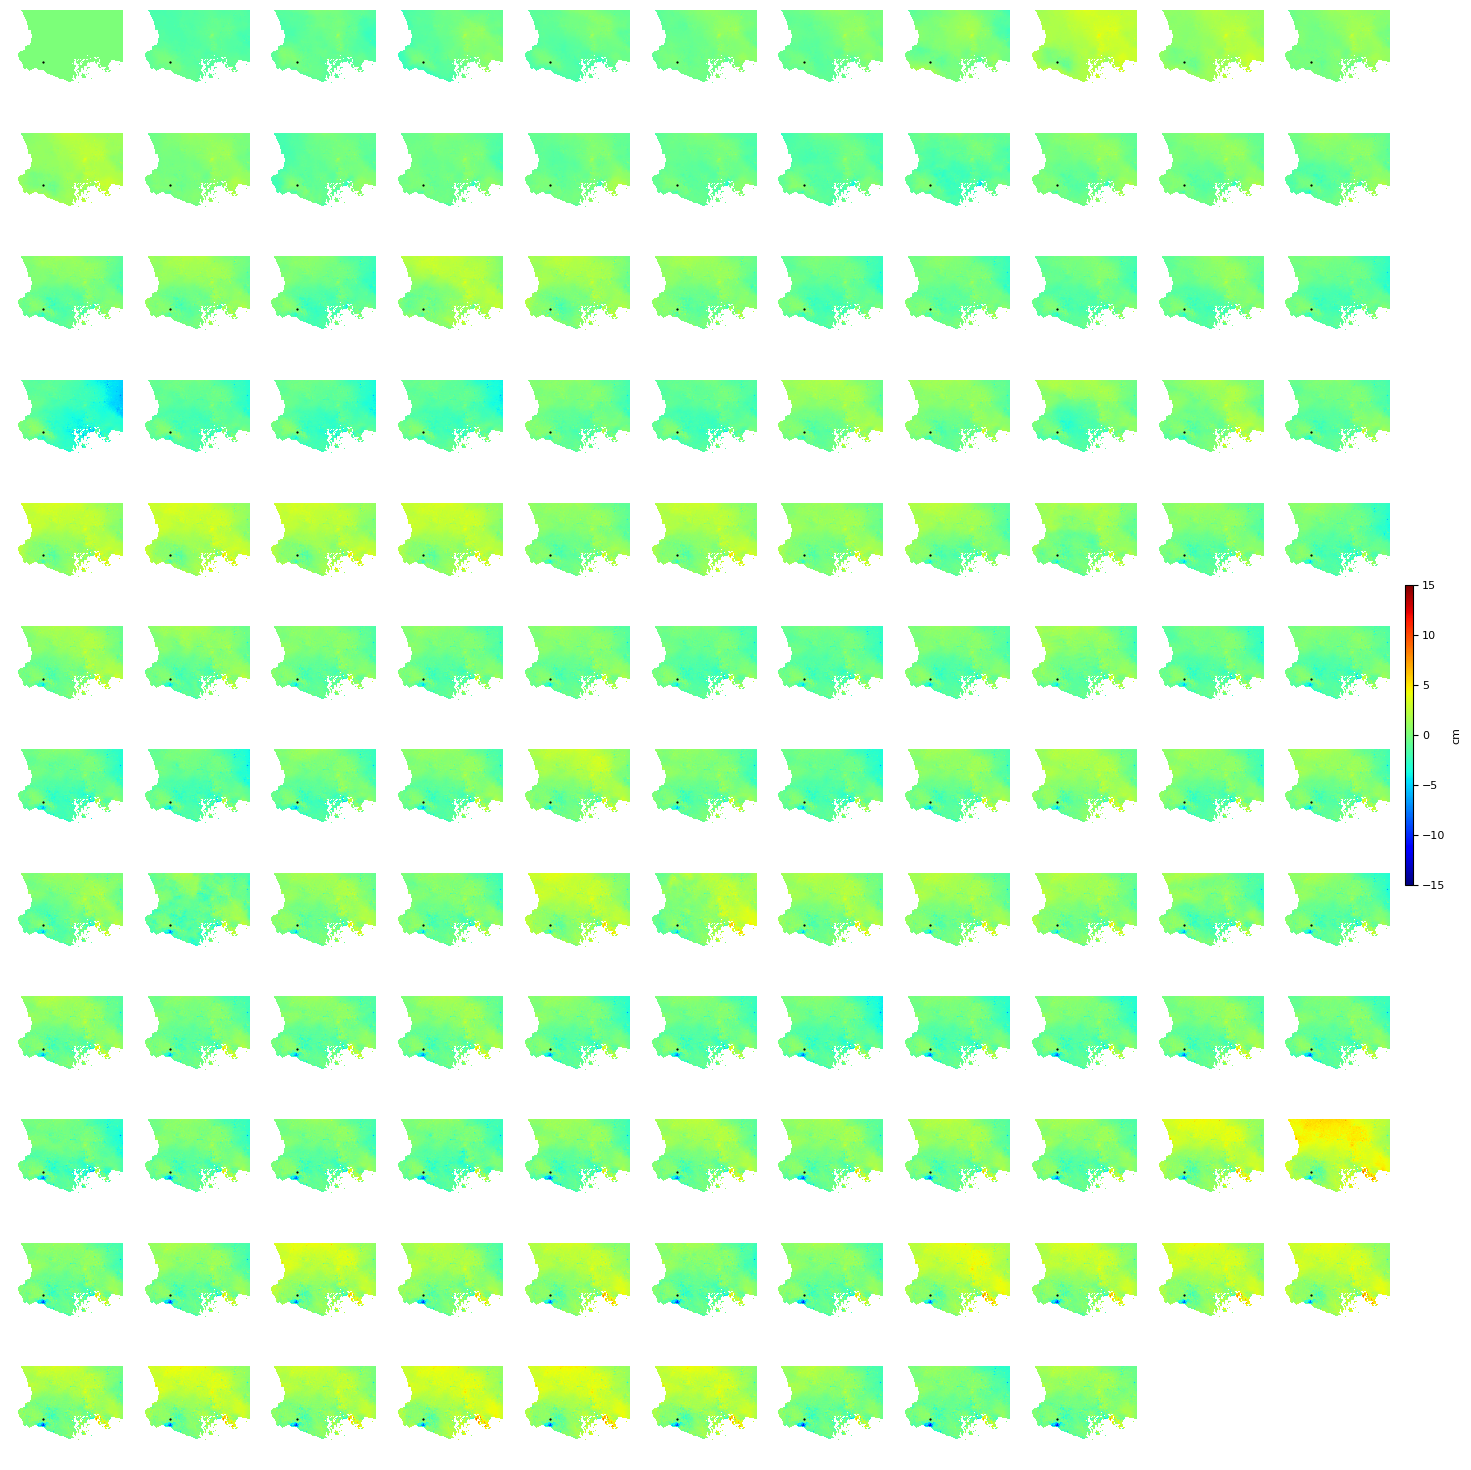

In [24]:
ts_demErr = f'/home/jovyan/GEOS657_MRS/2023/data_LA/MintPy/timeseries.h5'

scp_args = f'{ts_demErr} --wrap --wrap-range -15 15 --notitle --notick --noaxis --dpi 600 --figsize 15 15 --outfile /home/jovyan/GEOS657_MRS/2023/data_LA/MintPy/inverted_ts.png'
view.main(scp_args.split())

## 2.7 Estimating the Long-Term Velocity Rate

<font face="Calibri" size="3">The ground deformation caused by many geophysical or anthropogenic processes are linear at first order approximation. Therefore it is common to estimate the rate of the ground deformation, which is the slope of linear fit to the time-series. </font>

In [25]:
!smallbaselineApp.py LASenDT71.txt --dostep velocity

MintPy version 1.5.0, date 2022-11-18
--RUN-at-2023-04-20 04:18:03.619550--
Current directory: /home/jovyan/GEOS657_MRS/2023/data_LA/MintPy
Run routine processing with smallbaselineApp.py on steps: ['velocity']
Remaining steps: ['geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: LASenDT71
Go to work directory: /home/jovyan/GEOS657_MRS/2023/data_LA/MintPy
read custom template file: /home/jovyan/GEOS657_MRS/2023/data_LA/MintPy/LASenDT71.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/GEOS657_MRS/2023/data_LA/MintPy/smallbaselineApp.cfg
read default template file: /home/jovyan/GEOS657_MRS/2023/data_LA/MintPy/smallbaselineApp.cfg


******************** step - velocity ********************

timeseries2velocity.py /home/jovyan/GEOS657_MRS/2023/data_LA/MintPy/timeseries.h5 -t /home/jovyan/GEOS657_MRS/2023/data_LA/MintPy/smallbaselineApp.cfg -o /home/jovyan/GEOS657_MRS/2023/data

run view.py in MintPy version 1.5.0, date 2022-11-18
input file is velocity file: /home/jovyan/GEOS657_MRS/2023/data_LA/MintPy/velocity.h5 in float32 format
file size in y/x: (301, 361)
input dataset: "['velocity']"
turning glob search OFF for velocity file
num of datasets in file velocity.h5: 5
datasets to exclude (0):
[]
datasets to display (1):
['velocity']
data   coverage in y/x: (0, 0, 361, 301)
subset coverage in y/x: (0, 0, 361, 301)
data   coverage in lat/lon: (-118.450416667, 33.900416667, -118.149583454, 33.649583434)
subset coverage in lat/lon: (-118.450416667, 33.900416667, -118.149583454, 33.649583434)
------------------------------------------------------------------------
colormap: jet
figure title: velocity
figure size : [9.00, 6.00]
read mask from file: maskTempCoh.h5
reading data ...
masking data
data    range: [-2.5737917, 2.158178] cm/year
display range: [-1.0, 1.0] cm/year
display data in transparency: 1.0
plot in geo-coordinate
plotting image ...
plot scale bar: [

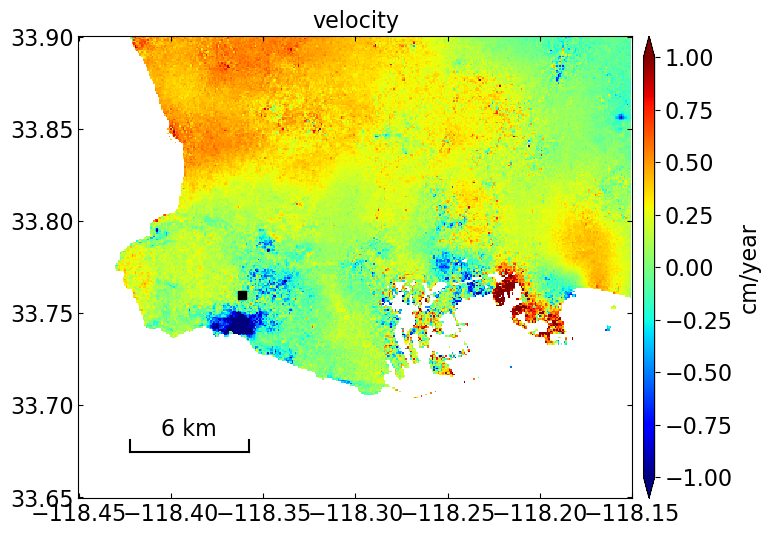

In [26]:
scp_args = 'velocity.h5 velocity -v -1 1'
view.main(scp_args.split())

<font face="Calibri" size="3">
<div class="alert alert-info">
<b>Note :</b> 
Negative values indicates that target is moving away from the radar (i.e., Subsidence in case of vertical deformation).
Positive values indicates that target is moving towards the radar (i.e., uplift in case of vertical deformation). 
    The line of sight (LOS) for this descending Sentinel-1 track is up and east from ground to radar.
</div>
</font>

<font face="Calibri" size="3"><b>Obvious features in the estimated velocity map:</b>

1) There are several features with significant velocity in this area. <br><br>

2) The negative LOS feature on the Palos Verdes peninsula (center left of map) is the Portuguese Bend Landslide, moving down and southwest toward the sea.

3) There are areas of positive and negative LOS change in the area of Long Beach (east part of map). These are due to the extraction of oil and injection of water in oilfields beneath the city and out in the harbor.

4) The block box at 33.76N, 118.36W is the reference pixel for this map, just north of the Portuguese Bend Landslide. 
</font>

<hr>

# 3. Error Analysis (Separating Signal from Noise)


<font face="Calibri" size="3">Uncertainty of the ground displacement products derived from InSAR time-series, depends on the quality of the inversion of the stack of interferograms and the accuracy in separating the ground displacement from other components of the InSAR data. Therefore the definition of signal vs noise is different at the two main steps in mintpy:  

1) During the inversion: 
    At this step all systematic components of the interferometric phase (e.g., ground displacement, propagation delay, geometrical residuals caused by DEM or platform's orbit inaccuracy) are considered signal, while the interferometric phase decorrelation, phase unwrapping error and phase inconsistency are considered noise. 
    
2) After inversion: the ground displacement component of the time-serieses is signal, and everything else (including the propagation delay and geometrical residuals) are considered noise

Therefore we first discuss the possible sources of error during the inversion and the existing ways in MintPy to evaluate the quality of inversion and to improve the uncertainty of the inversion. Afterwards we explain the different components of the time-series and the different processing steps in MintPy to separate them from ground displacement signal.  
</font>

## 3.1 Quality of the Inversion

<font face="Calibri" size="3">The main sources of noise during the time-series inversion includes decorrelation, phase unwrapping error and the inconsistency of triplets of interferofgrams. Here we mainly focus on the decorrelation and unwrapping errors. We first show the existing quantities in MintPy to evaluate decorrelation and unwrapping errors and then discuss the existing ways in MintPy to reduce the decorrelation and unwrapping errors on the time-series inversion.</font>

### 3.1.1 Average Spatial Coherence

<font face="Calibri" size="3">Mintpy computes temporal average of spatial coherence of the entire stack as a potential ancillary measure to choose reliable pixels after time-series inversion. </font>

run view.py in MintPy version 1.5.0, date 2022-11-18
input file is coherence file: /home/jovyan/GEOS657_MRS/2023/data_LA/MintPy/avgSpatialCoh.h5 in float32 format
file size in y/x: (301, 361)
num of datasets in file avgSpatialCoh.h5: 1
datasets to exclude (0):
[]
datasets to display (1):
['coherence']
data   coverage in y/x: (0, 0, 361, 301)
subset coverage in y/x: (0, 0, 361, 301)
data   coverage in lat/lon: (-118.450416667, 33.900416667, -118.149583454, 33.649583434)
subset coverage in lat/lon: (-118.450416667, 33.900416667, -118.149583454, 33.649583434)
------------------------------------------------------------------------
colormap: gray
figure title: avgSpatialCoh
figure size : [9.00, 6.00]
reading data ...
data    range: [0.0, 0.99384725] 1
display range: [0.0, 1.0] 1
display data in transparency: 1.0
plot in geo-coordinate
plotting image ...
plot scale bar: [0.2, 0.2, 0.1]
showing ...


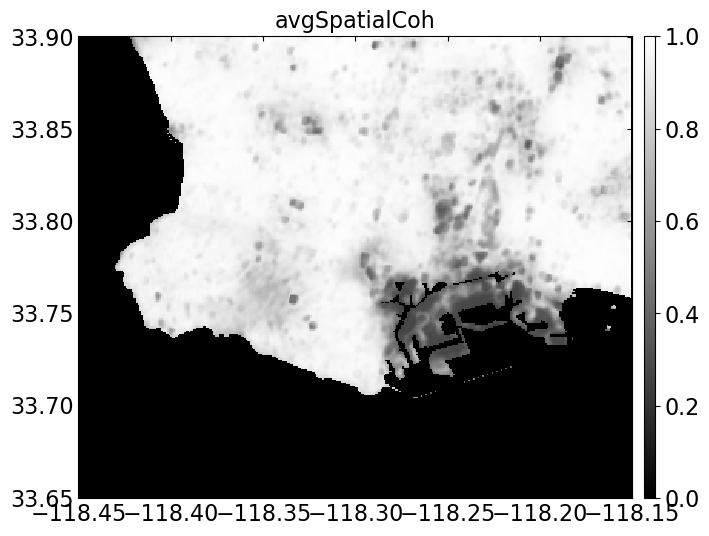

In [27]:
view.main(['avgSpatialCoh.h5'])

### 3.1.2 Temporal Coherence

<font face="Calibri" size="3">In addition to timeseries.h5 which contains the time-series dataset, invert_network produces other quantities, which contain metrics to evaluate the quality of the inversion including temporalCoherence.h5. Temporal coherence represents the consistency of the timeseries with the network of interferograms. 

Temporal coherence varies from 0 to 1. Pixels with values closer to 1 are considered reliable and pixels with values closer to zero are considered unreliable. For a dense network of interferograms, a threshold of 0.7 may be used (Yunjun et al, 2019). Here we are using a threshold of 0.5.</font>

run view.py in MintPy version 1.5.0, date 2022-11-18
input file is temporalCoherence file: /home/jovyan/GEOS657_MRS/2023/data_LA/MintPy/temporalCoherence.h5 in float32 format
file size in y/x: (301, 361)
num of datasets in file temporalCoherence.h5: 1
datasets to exclude (0):
[]
datasets to display (1):
['temporalCoherence']
data   coverage in y/x: (0, 0, 361, 301)
subset coverage in y/x: (0, 0, 361, 301)
data   coverage in lat/lon: (-118.450416667, 33.900416667, -118.149583454, 33.649583434)
subset coverage in lat/lon: (-118.450416667, 33.900416667, -118.149583454, 33.649583434)
------------------------------------------------------------------------
colormap: gray
figure title: temporalCoherence
figure size : [9.00, 6.00]
reading data ...
data    range: [0.0, 1.0] 1
display range: [0.0, 1.0] 1
display data in transparency: 1.0
plot in geo-coordinate
plotting image ...
plot scale bar: [0.2, 0.2, 0.1]
plot reference point
showing ...


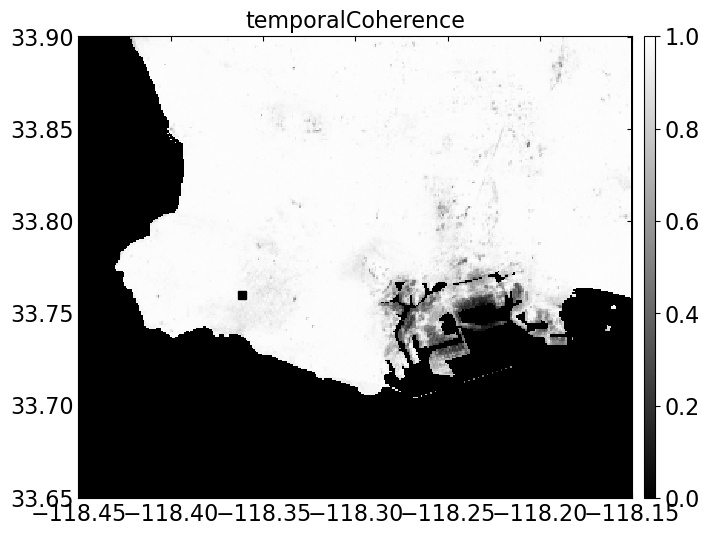

In [28]:
view.main(['temporalCoherence.h5'])

<font face="Calibri" size="3">With both the spatial coherence and temporal coherence, we can see that the InSAR in the ports of Long Beach and Los Angeles have unstable phase, and the InSAR measurements there will be low quality.</font>

## 3.2. Velocity Error Analysis

<font face="Calibri" size="3">The estimated velocity also comes with an expression of unecrtainty which is simply based on the goodness of fit while fitting a linear model to the time-series. This quantity is saved in "velocity.h5" under the velocityStd dataset. 

**Mintpy supports additional corrections in its processing not included in this demo:**
- Unwrapping error correction
- Tropospheric delay correction
- deramping
- Topographic residual correction
- Residual RMS for noise evaluation
- Changing the reference date
</font>

run view.py in MintPy version 1.5.0, date 2022-11-18
input file is velocity file: /home/jovyan/GEOS657_MRS/2023/data_LA/MintPy/velocity.h5 in float32 format
file size in y/x: (301, 361)
input dataset: "['velocityStd']"
turning glob search OFF for velocity file
num of datasets in file velocity.h5: 5
datasets to exclude (0):
[]
datasets to display (1):
['velocityStd']
data   coverage in y/x: (0, 0, 361, 301)
subset coverage in y/x: (0, 0, 361, 301)
data   coverage in lat/lon: (-118.450416667, 33.900416667, -118.149583454, 33.649583434)
subset coverage in lat/lon: (-118.450416667, 33.900416667, -118.149583454, 33.649583434)
------------------------------------------------------------------------
colormap: jet
figure title: velocityStd
figure size : [9.00, 6.00]
read mask from file: maskTempCoh.h5
reading data ...
masking data
data    range: [0.0, 0.122878306] cm/year
display range: [0.0, 0.2] cm/year
display data in transparency: 1.0
plot in geo-coordinate
plotting image ...
plot scale ba

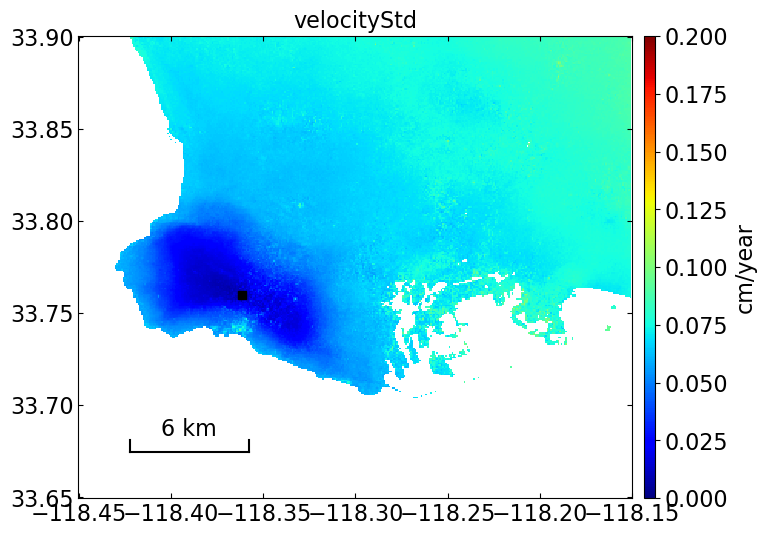

In [29]:
scp_args = 'velocity.h5 velocityStd -v 0 0.2'
view.main(scp_args.split())

<font face="Calibri" size="3">Note that the plot above is the velocity error, not the velocity. The errors generally increase with distance from the reference point and also increase for points with elevations different from the reference point because of topographically correlated water vapor variations that are especially strong in this area.</font>

<hr>

# 4. Plotting a Landslide Motion Transect 

run view.py in MintPy version 1.5.0, date 2022-11-18
input file is velocity file: /home/jovyan/GEOS657_MRS/2023/data_LA/MintPy/velocity.h5 in float32 format
file size in y/x: (301, 361)
input dataset: "['velocity']"
turning glob search OFF for velocity file
num of datasets in file velocity.h5: 5
datasets to exclude (0):
[]
datasets to display (1):
['velocity']
data   coverage in y/x: (0, 0, 361, 301)
subset coverage in y/x: (0, 0, 361, 301)
data   coverage in lat/lon: (-118.450416667, 33.900416667, -118.149583454, 33.649583434)
subset coverage in lat/lon: (-118.450416667, 33.900416667, -118.149583454, 33.649583434)
------------------------------------------------------------------------
colormap: jet
figure title: velocity
figure size : [9.00, 6.00]
read mask from file: maskTempCoh.h5
data    range: [-2.5737917, 2.158178] cm/year
display range: [-2.5737917, 2.158178] cm/year
figure size : [9.00, 6.00]
display data in transparency: 1.0
plot in geo-coordinate
plotting image ...
plot scal

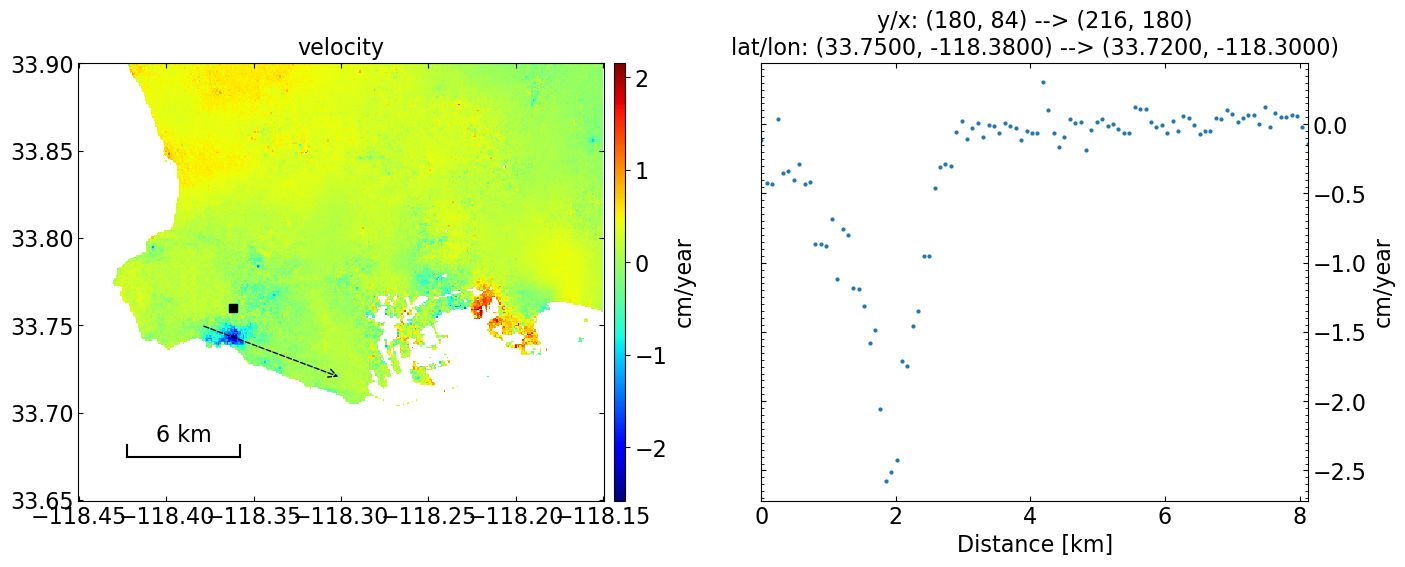

MintPy version 1.5.0, date 2022-11-18
--RUN-at-2023-04-20 04:18:26.503402--
Current directory: /home/jovyan/GEOS657_MRS/2023/data_LA/MintPy
Run routine processing with smallbaselineApp.py on steps: ['google_earth']
Remaining steps: ['hdfeos5']
--------------------------------------------------
Go to work directory: /home/jovyan/GEOS657_MRS/2023/data_LA/MintPy
read default template file: /home/jovyan/GEOS657_MRS/2023/data_LA/MintPy/smallbaselineApp.cfg


******************** step - google_earth ********************
creating Google Earth KMZ file for geocoded velocity file: ...

save_kmz.py /home/jovyan/GEOS657_MRS/2023/data_LA/MintPy/velocity.h5 -o /home/jovyan/GEOS657_MRS/2023/data_LA/MintPy/velocity.kmz
data   coverage in y/x: (0, 0, 361, 301)
subset coverage in y/x: (0, 0, 361, 301)
update LENGTH, WIDTH, Y/XMAX
update/add SUBSET_XMIN/YMIN/XMAX/YMAX: 0/0/361/301
update Y/X_FIRST
update REF_Y/X
read mask from file: maskTempCoh.h5
masking out pixels with zero value in file: None
colorma

In [30]:
scp_args = 'velocity.h5 --start-lalo 33.75 -118.38 --end-lalo 33.72 -118.3 '
plot_transection.main(scp_args.split())

!smallbaselineApp.py smallbaselineApp.cfg --dostep google_earth

<font face="Calibri" size="3">On this transect, the Portuguese Bend Landslide has an average velocity over the last five years that reaches more than 2.5 cm/year in the descending track radar LOS direction (note that the "zero" is about -5 so we have to subtract that first). By analyzing the velocity on the ascending track and combining the two LOS directions, then we could find out that the displacments are largely horizontal, westward (and southward that we can't see with InSAR).</font>

<hr>

# 5. Compare InSAR time-series with GPS time-series in LOS direction

We will compare the InSAR deformation measurements with GPS observations. To do that we utilize the GPS holdings provided by the University of Reno Nevada, who provide access to a global network of GPS stations. You can look up their resources under the following links
- http://geodesy.unr.edu/NGLStationPages/gpsnetmap/GPSNetMap.html
- http://geodesy.unr.edu/NGLStationPages/DataHoldings.txt

We use MintPy functions to project the 3-dimensional GPS measurements into the line-of-sight of the SAR observations.

## 5.1. Identify Potential GPS stations

In [44]:
mint_path='/home/jovyan/GEOS657_MRS/2023/data_LA/MintPy'
with asfn.work_dir('/home/jovyan/GEOS657_MRS/2023/data_LA/MintPy'):
    url = 'http://geodesy.unr.edu/NGLStationPages/DataHoldings.txt'
    response = urllib.request.urlopen(url, timeout=5)
    content = response.read()
    rows = content.decode('utf-8').splitlines()
    holdings_txt = Path('.')/'DataHoldings.txt'
    if holdings_txt.exists():
        holdings_txt.unlink()

with open(f'/home/jovyan/GEOS657_MRS/2023/data_LA/MintPy/GPS_stations.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile, delimiter=',', escapechar=',', quoting=csv.QUOTE_NONE)
    for row in rows:
        csv_writer.writerow([re.sub('\s+', ' ', row)])

## 5.2 Build a list of GPS stations within your area of interest and select one

In [58]:
# get the InSAR stack's corner coordinates
with h5py.File(f"{mint_path}/inputs/geometryGeo.h5", 'r') as f:
    lon_west = float(f.attrs['LON_REF1'])
    lon_east = float(f.attrs['LON_REF2'])
    lat_south = float(f.attrs['LAT_REF1'])
    lat_north = float(f.attrs['LAT_REF3'])

# get the start and end dates of the timeseries
info = gdal.Info(f"{mint_path}/timeseries.h5", format='json')
ts_start = info['metadata']['']['START_DATE']
ts_start = datetime.strptime(ts_start, '%Y%m%d')
ts_end = info['metadata']['']['END_DATE']
ts_end = datetime.strptime(ts_end, '%Y%m%d')

# find all stations that have data within the ts time range,
# are located within the AOI and at an unmasked pixel location
gps_stations = list()
with open(f'{mint_path}/GPS_stations.csv', newline='') as csvfile:
    csv_reader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    for row in list(csv_reader)[1:]:
        begin_date = datetime.strptime(row[7], '%Y-%m-%d')
        mod_date = datetime.strptime(row[9], '%Y-%m-%d')
        lat = float(row[1])
        
        # print('begin_date: ', begin_date)
        # print('mod_date: ', mod_date)
        # print('lat: ', lat, '\n')
        
        if float(row[2]) > 180:
            lon = float(row[2]) - 360
        else:
            lon = float(row[2])

        n = [lat, lon]
        a = [lat_north, lon_west]
        b = [lat_south, lon_west]
        c = [lat_south, lon_east]
        ab = np.subtract(a, b)
        an = np.subtract(a, n)
        bc = np.subtract(b, c)
        bn = np.subtract(b, n)

        in_aoi = 0 <= np.dot(ab, an) <= np.dot(ab, ab) and 0 <= np.dot(bc, bn) <= np.dot(bc, bc)
        in_date_range = ts_start >= begin_date and ts_end <= mod_date
        
        if in_aoi and in_date_range:
            vel_file = f'{mint_path}/velocity.h5'
            atr = mintpy.utils.readfile.read_attribute(vel_file)
            coord = mintpy.utils.utils.coordinate(atr, lookup_file=f'{mint_path}/inputs/geometryRadar.h5')
            y, x = coord.geo2radar(lat, lon)[:2]
            msk = mintpy.utils.readfile.read(f'{mint_path}/maskTempCoh.h5')[0]
            box = (x, y, x+1, y+1)
            masked = not msk[y, x]
            if not masked:
                gps_stations.append(row[0].strip())
                
if len(gps_stations) > 0:
    gps_station = asfn.select_parameter(gps_stations)
    print("Select a GPS station")
    display(gps_station)
else:
    print("No GPS stations found.")

Select a GPS station


RadioButtons(layout=Layout(min_width='800px'), options=('CAPE', 'CCCO', 'CRHS', 'CSDH', 'ECCO', 'HBCO', 'LBC2'…

## 5.3 Plot InSAR Velocities Referenced to your Selected GPS Station

run view.py in MintPy version 1.5.0, date 2022-11-18
input file is velocity file: /home/jovyan/GEOS657_MRS/2023/data_LA/MintPy/velocity.h5 in float32 format
file size in y/x: (301, 361)
input dataset: "['velocity']"
turning glob search OFF for velocity file
num of datasets in file velocity.h5: 5
datasets to exclude (0):
[]
datasets to display (1):
['velocity']
data   coverage in y/x: (0, 0, 361, 301)
subset coverage in y/x: (0, 0, 361, 301)
data   coverage in lat/lon: (-118.450416667, 33.900416667, -118.149583454, 33.649583434)
subset coverage in lat/lon: (-118.450416667, 33.900416667, -118.149583454, 33.649583434)
------------------------------------------------------------------------
colormap: jet
figure title: velocity
read mask from file: maskTempCoh.h5
reading data ...
masking data
data    range: [-2.5737917, 2.158178] cm/year
display range: [-2.5737917, 2.158178] cm/year
display data in transparency: 1.0
plot in geo-coordinate
plotting image ...
referencing InSAR data to the pix

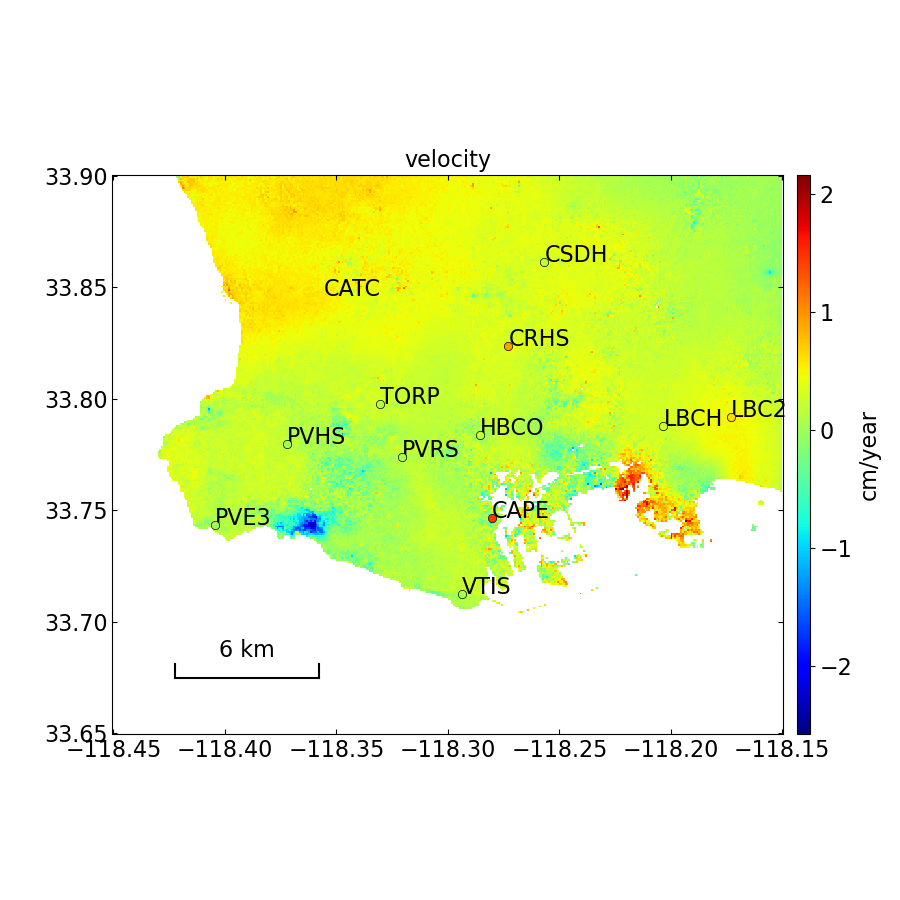

In [59]:
%matplotlib widget
if len(gps_stations) > 0:
    scp_args = f"{mint_path}/velocity.h5 velocity --show-gps --ref-gps {gps_station.value} --gps-comp enu2los --gps-label --figsize 9 9"
    with asfn.work_dir(mint_path):
        view.main(scp_args.split())

<hr>

# 6. Plot the Cumulative Displacement Map and Point Displacement Time Series

Finally, we can plot the cumulative displacement estimates for selected points. To do so, follow these steps:
- Use the `Time` bar below the Cumulative Displacement Map to view displacements for different time periods
- Click on the Cumulative Displacement Map to select points for displaying Point Displacement Time-Series

tsview.py /home/jovyan/GEOS657_MRS/2023/data_LA/MintPy/timeseries.h5 -d=/home/jovyan/GEOS657_MRS/2023/data_LA/MintPy/inputs/geometryGeo.h5 -o=/home/jovyan/GEOS657_MRS/2023/data_LA/MintPy/displacement_ts --outfile=/home/jovyan/GEOS657_MRS/2023/data_LA/MintPy/displacement_ts.pdf
open timeseries file: timeseries.h5
No lookup table info range/lat found in files.
data   coverage in y/x: (0, 0, 361, 301)
subset coverage in y/x: (0, 0, 361, 301)
data   coverage in lat/lon: (-118.450416667, 33.900416667, -118.149583454, 33.649583434)
subset coverage in lat/lon: (-118.450416667, 33.900416667, -118.149583454, 33.649583434)
------------------------------------------------------------------------
estimate deformation model with the following assumed time functions:
    polynomial : 1
    periodic   : []
    stepDate   : []
    exp        : {}
    log        : {}
reading timeseries from file /home/jovyan/GEOS657_MRS/2023/data_LA/MintPy/timeseries.h5
reference to date: 20150514
read mask from file: 

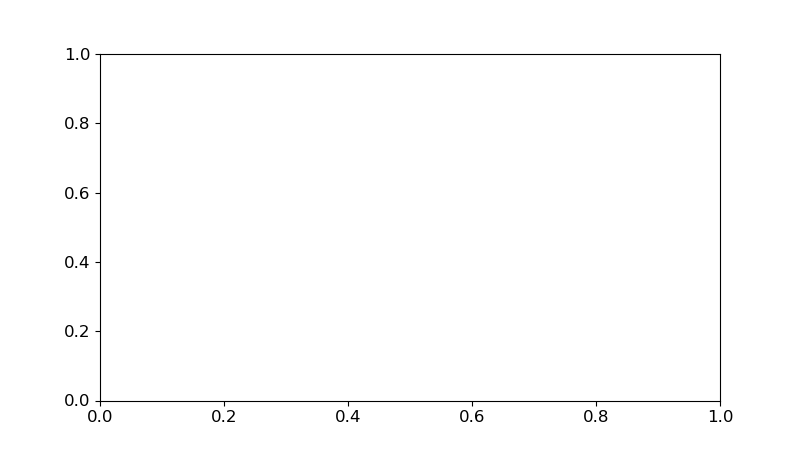

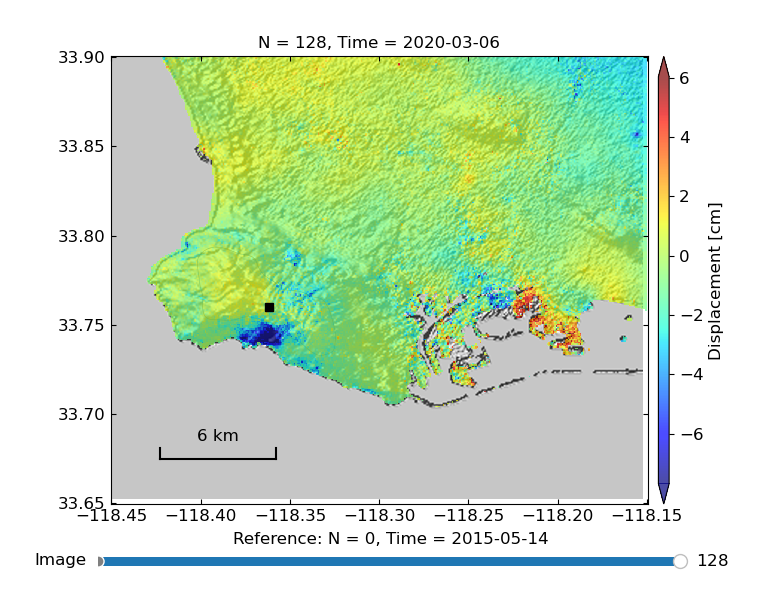

In [60]:
%matplotlib widget

tsview.main([str(ts_demErr), 
                    f'-d={mint_path}/inputs/geometryGeo.h5', 
                    f'-o={mint_path}/displacement_ts', 
                    f'--outfile={mint_path}/displacement_ts.pdf'])

<hr>

# 7. Reference Material

<font face="Calibri" size="3">

- Original Notebook withe detailed description by Yunjun and Fattahi at: https://nbviewer.jupyter.org/github/insarlab/MintPy-tutorial/blob/master/smallbaselineApp_aria.ipynb

- Mintpy reference: *Yunjun, Z., H. Fattahi, F. Amelung (2019), Small baseline InSAR time series analysis: unwrapping error correction and noise reduction, preprint doi:[10.31223/osf.io/9sz6m](https://eartharxiv.org/9sz6m/).*

- University of Miami online time-series viewer: https://insarmaps.miami.edu/

- Mintpy Github repository: https://github.com/insarlab/MintPy

- ARIA-tools Github Repository: https://github.com/aria-tools/ARIA-tools
</font>

<hr>

# 6. Change Log

<font face="Calibri" size="2"> <i>LosAngeles_time_series.ipynb - Version 1.2.2 - April 2023
<br>
    <b>Version Changes</b>
    <ul>
        <li>url_widget</li>
        <li>Added GPS and time series sections</li>
    </ul></i>
</font>